We've looked a lot at different dither functions, btu mostly at the end of th 10-year survey. It might be a good idea to check the time evolution of the co-added depth power spectrum.  

In [1]:
%matplotlib inline
import numpy as np
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.utils as utils
import healpy as hp

In [2]:
opsdb = db.OpsimDatabase('minion_1016_sqlite.db')
propids, propTags = opsdb.fetchPropInfo()
wfdWhere = utils.createSQLWhere('WFD', propTags)
outDir = 'null'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
nside = 128


In [4]:
class HexDitherNightStacker_bigOffFirst(stackers.HexDitherFieldNightStacker): 
    """
    Just like HexDitherNightStacker, just changing the order of the offsets so that 
    the biggest offsets are done first, and smallest last.
    """
    def __init__(self, reverse=True, raCol='fieldRA', decCol='fieldDec', fieldIdCol='fieldIdCol', 
                 nightCol='night', maxDither=1.8, inHex=True):
        super(HexDitherNightStacker_bigOffFirst,self).__init__(raCol=raCol, decCol=decCol,
                                                              fieldIdCol=fieldIdCol, nightCol=nightCol,
                                                              maxDither=maxDither, inHex=inHex)
        self.reverse = reverse
    def _generateHexOffsets(self):
        super(HexDitherNightStacker_bigOffFirst, self)._generateHexOffsets()
        # New part to order things differently
        radius_off_sq = self.xOff**2 + self.yOff**2
        newOrder = np.argsort(radius_off_sq)
        if self.reverse:
            print 'doing big dithers'
            newOrder = newOrder[::-1]
        else:
            print 'Doing small dithers'
        self.xOff = self.xOff[newOrder]
        self.yOff = self.yOff[newOrder]

In [5]:
class HexDither_small(stackers.HexDitherFieldVisitStacker):
    """
    Use offsets from the hexagonal grid of 'hexdither', but visit each vertex sequentially.
    Sequential offset for each night of visits.
    """
    def __init__(self, raCol='fieldRA', decCol='fieldDec', fieldIdCol='fieldIdCol', nightCol='night', maxDither=1.8, inHex=True):
        """
        @ MaxDither in degrees
        """
        super(HexDither_small, self).__init__(raCol=raCol, decCol=decCol, maxDither=maxDither, inHex=inHex)
        self.nightCol = nightCol
        # Values required for framework operation: this specifies the names of the new columns.
        self.colsAdded = ['ra_small', 'dec_small']
        # Values required for framework operation: this specifies the data columns required from the database.
        self.colsReq.append(self.nightCol)

    def _generateHexOffsets(self):
        super(HexDither_small, self)._generateHexOffsets()
        # New part to order things differently
        radius_off_sq = self.xOff**2 + self.yOff**2
        newOrder = np.argsort(radius_off_sq)
        print 'Doing small dithers'
        self.xOff = self.xOff[newOrder]
        self.yOff = self.yOff[newOrder]
        
    def _run(self, simData):
        self._generateHexOffsets()
        for fieldid in np.unique(simData[self.fieldIdCol]):
            # Identify observations of this field.
            match = np.where(simData[self.fieldIdCol] == fieldid)[0]
            # Apply a sequential dither, increasing each night.
            vertexIdxs = np.arange(0, len(match), 1)
            nights = simData[self.nightCol][match]
            vertexIdxs = np.searchsorted(np.unique(nights), nights)
            vertexIdxs = vertexIdxs % self.numPoints
            simData['ra_small'][match] = simData[self.raCol][match] + \
              self.xOff[vertexIdxs]/np.cos(simData[self.decCol][match])
            simData['dec_small'][match] = simData[self.decCol][match] + self.yOff[vertexIdxs]
        # Wrap into expected range.
        simData['ra_small'], simData['dec_small'] = \
          stackers.wrapRADec(simData['ra_small'], simData['dec_small'])
        return simData


In [6]:
class HexDither_big(stackers.HexDitherFieldVisitStacker):
    """
    Use offsets from the hexagonal grid of 'hexdither', but visit each vertex sequentially.
    Sequential offset for each night of visits.
    """
    def __init__(self, raCol='fieldRA', decCol='fieldDec', fieldIdCol='fieldIdCol', nightCol='night', maxDither=1.8, inHex=True):
        """
        @ MaxDither in degrees
        """
        super(HexDither_big, self).__init__(raCol=raCol, decCol=decCol, maxDither=maxDither, inHex=inHex)
        self.nightCol = nightCol
        # Values required for framework operation: this specifies the names of the new columns.
        self.colsAdded = ['ra_big', 'dec_big']
        # Values required for framework operation: this specifies the data columns required from the database.
        self.colsReq.append(self.nightCol)

    def _generateHexOffsets(self):
        super(HexDither_big, self)._generateHexOffsets()
        # New part to order things differently
        radius_off_sq = self.xOff**2 + self.yOff**2
        newOrder = np.argsort(radius_off_sq)[::-1]
        print 'Doing big dithers'
        self.xOff = self.xOff[newOrder]
        self.yOff = self.yOff[newOrder]
        
    def _run(self, simData):
        self._generateHexOffsets()
        for fieldid in np.unique(simData[self.fieldIdCol]):
            # Identify observations of this field.
            match = np.where(simData[self.fieldIdCol] == fieldid)[0]
            # Apply a sequential dither, increasing each night.
            vertexIdxs = np.arange(0, len(match), 1)
            nights = simData[self.nightCol][match]
            vertexIdxs = np.searchsorted(np.unique(nights), nights)
            vertexIdxs = vertexIdxs % self.numPoints
            simData['ra_big'][match] = simData[self.raCol][match] + \
              self.xOff[vertexIdxs]/np.cos(simData[self.decCol][match])
            simData['dec_big'][match] = simData[self.decCol][match] + self.yOff[vertexIdxs]
        # Wrap into expected range.
        simData['ra_big'], simData['dec_big'] = \
          stackers.wrapRADec(simData['ra_big'], simData['dec_big'])
        return simData

In [7]:
bundleList = []
plotFuncs = [plots.TwoDMap()]
survey_length = 5.  # Years
sql = 'filter = "r" and night < %f and ' % (365.25*survey_length) + wfdWhere
step_size = 20. # Days
bins = np.arange(0,365.25*survey_length+step_size,step_size)
#stacker = HexDitherNightStacker_bigOffFirst(reverse=False)  # try out the hex dither per night 
slicer =  slicers.HealpixSlicer(nside=nside, lonCol='ra_small', latCol='dec_small')
metric = metrics.AccumulateM5Metric(bins=bins, metricName='M5_regularsteps')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, plotFuncs=plotFuncs))

#stacker = HexDitherNightStacker_bigOffFirst(reverse=True)
#slicer = slicers.HealpixSlicer(nside=nside, lonCol='randomDitherFieldNightRa', latCol='randomDitherFieldNightDec')
slicer =  slicers.HealpixSlicer(nside=nside, lonCol='ra_big', latCol='dec_big')
metric = metrics.AccumulateM5Metric(bins=bins, metricName='M5_bigsteps1st')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql,  plotFuncs=plotFuncs))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [8]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database with constraint filter = "r" and night < 1826.250000 and propID = 54
Found 196315 visits
Running:  ['opsim_M5_bigsteps1st_r_and_night_lt_1826_250000_and_propID_54_HEAL']
Doing big dithers
Completed metric generation.
Running:  ['opsim_M5_regularsteps_r_and_night_lt_1826_250000_and_propID_54_HEAL']
Doing small dithers
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with filter = "r" and night < 1826.250000 and propID = 54 sqlconstraint now.
Plotting complete.


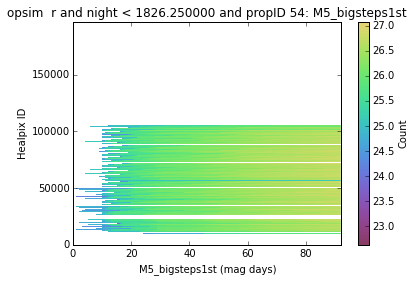

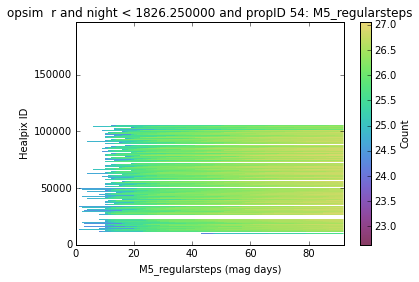

In [9]:
bg.plotAll(closefigs=False)

In [10]:
ack = bundleList[0].metricValues - bundleList[1].metricValues
ack.max()

2.2633239669108463